In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import networkx as nx
import mygene
import torch
import math

In [63]:
current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Data', 'RNA_dataset_tabular_R3.csv'))

# expression data
tabular_data = pd.read_csv(somepath, sep = ',', index_col = 0)
tabular_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,SLC17A1,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP,WNT16,PFS,CENSOR
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,4.47,7.07,5.23,4.08,8.68,7.09,4.94,0.01,4.172485,0.0
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,4.45,7.40,6.84,2.84,6.08,6.56,4.61,0.01,16.591376,1.0
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,2.94,6.66,5.81,4.16,6.33,7.14,8.42,0.01,11.104723,0.0
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,0.83,6.67,5.27,4.12,6.97,6.73,6.28,0.01,14.028747,1.0
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,6.70,6.53,5.84,4.35,5.67,6.66,4.93,0.01,12.418891,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X50772aa64efb859960b20f8801cd6f58,6.27,3.78,3.98,5.95,4.66,7.18,4.61,8.04,6.62,5.80,...,7.81,7.26,6.15,3.52,5.92,6.74,5.48,0.01,4.271047,0.0
X91bcd3067a1a7954692d836515e04869,6.12,3.94,3.25,6.09,4.98,7.32,5.02,8.21,6.71,5.89,...,0.01,6.38,5.20,4.05,7.84,7.59,7.59,0.01,2.496920,0.0
Xc7439a06ffa32b313b0ec1b987b992a2,5.91,3.62,3.34,5.80,8.86,8.69,4.52,8.15,5.77,6.85,...,7.31,6.76,7.12,3.25,6.81,6.82,5.27,0.01,6.505133,1.0


In [121]:
X = tabular_data.drop(['PFS', 'CENSOR'], axis = 1)
maxVal = max([x for L in X.values for x in L])
X_normalized = X / maxVal

X_normalized['PFS'] = tabular_data['PFS']
X_normalized['CENSOR'] = tabular_data['CENSOR']

return X_normalized


,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,SLC17A1,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP,WNT16,PFS,CENSOR
id,,,,,,,,,,,,,,,,,,,,,
X105622fadc33f23755ac2df823110aca,0.324792,0.213325,0.110826,0.327354,0.360026,0.421525,0.278027,0.475336,0.393978,0.311339,...,0.285074,0.474055,0.438181,0.181935,0.389494,0.420243,0.295324,0.000641,16.591376,1.0
X293dd1284496215e9a0eca9f17a98e7e,0.372838,0.275464,0.220372,0.413197,0.311339,0.477258,0.313901,0.537476,0.437540,0.365151,...,0.053171,0.427290,0.337604,0.263933,0.446509,0.431134,0.402306,0.000641,14.028747,1.0
Xf4a6a5a1450a8448882e1c0aebc0eea5,0.362588,0.315183,0.174247,0.370916,0.296605,0.452274,0.311339,0.495836,0.397181,0.384369,...,0.328635,0.435618,0.376041,0.240231,0.500320,0.402947,0.616272,0.000641,13.831622,1.0
Xf7ee4a331a8fd70edc240dff978c170d,0.413837,0.281871,0.178732,0.419603,0.305573,0.499680,0.323511,0.490711,0.435618,0.387572,...,0.174247,0.445868,0.405509,0.292120,0.368354,0.429212,0.355541,0.000641,13.897331,1.0
Xff8fbe2fe76c82d429d4fa1d315f3b93,0.397181,0.300448,0.164638,0.400384,0.309417,0.512492,0.324151,0.533632,0.401666,0.370916,...,0.373479,0.414478,0.362588,0.251121,0.419603,0.422165,0.306214,0.000641,11.203285,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X50772aa64efb859960b20f8801cd6f58,0.401666,0.242152,0.254965,0.381166,0.298527,0.459962,0.295324,0.515054,0.424087,0.371557,...,0.500320,0.465086,0.393978,0.225496,0.379244,0.431775,0.351057,0.000641,4.271047,0.0
X91bcd3067a1a7954692d836515e04869,0.392056,0.252402,0.208200,0.390135,0.319026,0.468930,0.321589,0.525945,0.429853,0.377322,...,0.000641,0.408712,0.333120,0.259449,0.502242,0.486227,0.486227,0.000641,2.496920,0.0
Xc7439a06ffa32b313b0ec1b987b992a2,0.378603,0.231903,0.213965,0.371557,0.567585,0.556694,0.289558,0.522101,0.369635,0.438821,...,0.468290,0.433056,0.456118,0.208200,0.436259,0.436899,0.337604,0.000641,6.505133,1.0


In [88]:
A = tabular_data[tabular_data['CENSOR'] == 0].index
B = tabular_data[tabular_data['CENSOR'] == 1].index
Idxs = []

size = len(tabular_data)
lengths = (0.7, 0.2, 0.1)

step = max(math.ceil(len(B) / len(A)), 1)
print(step)

i = 0
a = 0
b = 0
for l in lengths:
    tmp = []
    tmp_i = i
    while (i < tmp_i + int(size*l)):
        if ((i % step == 0 and a < len(A)) or (b >= len(B))):
            tmp.append(A[a])
            a += 1
        else:
            tmp.append(B[b])
            b += 1
        i += 1
    Idxs += [tmp]

train, test, val = tabular_data.loc[Idxs[0]], tabular_data.loc[Idxs[1]], tabular_data.loc[Idxs[2]]

2


In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming tabular_data is your DataFrame
A_indices = tabular_data[tabular_data['CENSOR'] == 0].index
B_indices = tabular_data[tabular_data['CENSOR'] == 1].index

# Splitting A_indices into training, testing, and validation sets
A_train, A_temp = train_test_split(A_indices, test_size=0.3, random_state=42)
A_test, A_val = train_test_split(A_temp, test_size=0.1/0.3, random_state=42)

# Splitting B_indices into training, testing, and validation sets
B_train, B_temp = train_test_split(B_indices, test_size=0.3, random_state=42)
B_test, B_val = train_test_split(B_temp, test_size=0.1/0.3, random_state=42)

# Combining the sets
train_indices = list(A_train) + list(B_train)
test_indices = list(A_test) + list(B_test)
val_indices = list(A_val) + list(B_val)

# Creating the sets
train_set = tabular_data.loc[train_indices]
test_set = tabular_data.loc[test_indices]
val_set = tabular_data.loc[val_indices]


In [72]:
step = max(len(B) // len(A), 1) + 1
step

2

In [101]:
train_set['CENSOR'].value_counts()

CENSOR
1.0    257
0.0    180
Name: count, dtype: int64

In [102]:
test_set['CENSOR'].value_counts()

CENSOR
1.0    73
0.0    51
Name: count, dtype: int64

In [103]:
val_set['CENSOR'].value_counts()

CENSOR
1.0    38
0.0    27
Name: count, dtype: int64

-------------------

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = tabular_data.drop(columns=['PFS'])
Y = tabular_data['PFS']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns, index = X_test.index)

Y_train

id
Xf7ee4a331a8fd70edc240dff978c170d    13.897331
X5cabb9f0afcc6ec89f28a72e66b75c5b     3.909651
X2069a43cf26725e339dae5a64490a17f     1.379877
X3cdb45cfe9ffaac83f36c75e4af759e6     3.745380
X8783adc097e910b52c11f50e2a4aff2a     9.626283
                                       ...    
Xe1b0f87c25889df31bc0fe76a68853b6    12.517454
X502dfff1180e1952d964196c8493633b     0.032854
Xfdb742505b30978af60b426c93a32f9e     5.585216
X5db2ba740f908fe3a3e6832d48949346     1.412731
X490b3aaf0b34d71712e894ca670bff00     7.030801
Name: PFS, Length: 580, dtype: float64

In [34]:
torch.tensor(Y_train.values)

tensor([13.8973,  3.9097,  1.3799,  3.7454,  9.6263, 19.3511,  6.8994,  8.5749,
         1.6099,  6.9651,  5.6509,  4.2382,  2.5626,  8.4107,  1.2485,  1.4127,
         7.1622,  4.2053,  6.9322,  8.3121,  7.0308,  8.3450,  8.3450,  6.9322,
        12.3203,  1.4127,  0.4928,  1.4127, 11.3018,  2.8583,  1.4127,  8.2464,
         4.1725,  6.9322,  0.0329,  4.1725,  6.8994,  8.1150, 13.8316, 18.0041,
        16.6571,  2.8583,  4.1725,  1.4127,  4.4353,  5.4209, 10.8419,  2.7926,
         1.4127,  3.0226,  5.8480,  6.7680, 11.0719,  8.0493,  2.9240,  2.6283,
        14.0616, 12.6160,  2.7926, 12.2546,  5.5524,  4.2053,  6.9322,  6.9322,
         8.3121,  8.3121,  5.6181, 12.5832,  4.8296,  4.1396,  9.9220,  4.1068,
         8.3778, 11.1704,  4.1725,  8.3121,  1.4456,  5.6181, 20.7967,  3.2526,
        13.8645,  1.5113,  1.4456,  9.6591,  9.6920,  9.7577, 12.4517, 15.3101,
         9.6920,  5.7823,  7.7207,  7.0965,  9.5934, 23.6222,  2.7926,  1.5770,
         5.5524,  1.3799,  2.8583, 11.17

In [30]:
dataobj = X_train.iloc[0]
dataobj = torch.tensor(dataobj.values)
dataobj.reshape(-1, len(dataobj))

tensor([[0.6465, 0.4970, 0.4626,  ..., 0.4338, 0.3231, 0.0000]],
       dtype=torch.float64)

In [7]:
current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Data', 'RNA_dataset_graph_R3.pkl'))

with open(somepath, 'rb') as f:
    loaded_object = pickle.load(f)

In [8]:
loaded_object

In [38]:
x = [[[1,2,3],[4,5,6],[7,8,9]],[[1,2,3],[4,5,6],[7,8,9]],[[1,2,3],[4,5,6]]]
x

[[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
 [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
 [[1, 2, 3], [4, 5, 6]]]

In [42]:
[j for i in x for j in i]

[[1, 2, 3],
 [4, 5, 6],
 [7, 8, 9],
 [1, 2, 3],
 [4, 5, 6],
 [7, 8, 9],
 [1, 2, 3],
 [4, 5, 6]]

In [44]:
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

X, y = load_breast_cancer()
y

array([( True,  723.), (False, 6591.), ( True,  524.), (False, 6255.),
       ( True, 3822.), (False, 6507.), (False, 5947.), (False, 5816.),
       (False, 6007.), ( True, 1233.), ( True, 1136.), (False, 5984.),
       (False, 6249.), ( True, 4066.), ( True,  690.), ( True,  994.),
       ( True,  434.), ( True, 1743.), ( True, 2863.), (False, 5693.),
       (False, 5823.), (False, 5785.), (False, 5661.), (False, 2909.),
       ( True, 1171.), (False, 5110.), (False, 5533.), (False, 5571.),
       (False, 5519.), (False, 5379.), (False, 4675.), (False, 4652.),
       (False, 4227.), ( True,  910.), (False, 4472.), ( True, 1206.),
       (False, 7057.), (False,  958.), (False, 5359.), (False, 5945.),
       (False, 5651.), ( True,  528.), ( True,  796.), (False, 5685.),
       ( True, 1023.), (False, 4791.), (False, 1215.), (False, 3779.),
       (False, 5306.), (False, 5678.), ( True,  421.), (False, 5612.),
       ( True, 3121.), (False, 1104.), (False, 4691.), (False, 5238.),
      

In [2]:
import matplotlib.pyplot as plt

In [14]:
start = 0.0001
stop = 0.1
step = 0.0001

# Generate the linearly spaced numbers
linear_numbers = np.arange(start, stop + step, step)
linear_numbers

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004 ,
       0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047, 0.0048,
       0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056,
       0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063, 0.0064,
       0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071, 0.0072,
       0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008 ,
       0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088,
       0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.0096,
       0.0097, 0.0098, 0.0099, 0.01  , 0.0101, 0.0102, 0.0103, 0.0104,
       0.0105, 0.0106, 0.0107, 0.0108, 0.0109, 0.011 , 0.0111, 0.0112,
      

In [78]:
data_tr = {'MSE' : [], 'SPARSE': [], 'SLAT': []}
for i in range(20):
    data_tr['MSE'] += [i]
    data_tr['SPARSE'] += [i+0.3]
    data_tr['SLAT'] += [i+2]
data_tr

{'MSE': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'SPARSE': [0.3,
  1.3,
  2.3,
  3.3,
  4.3,
  5.3,
  6.3,
  7.3,
  8.3,
  9.3,
  10.3,
  11.3,
  12.3,
  13.3,
  14.3,
  15.3,
  16.3,
  17.3,
  18.3,
  19.3],
 'SLAT': [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21]}

In [68]:
combined_tr = [sum(values) for values in zip(*[data_tr[key] for key in data_tr.keys()])]
combined_tr

[0.43,
 3.4299999999999997,
 6.43,
 9.43,
 12.43,
 15.43,
 18.43,
 21.43,
 24.43,
 27.43,
 30.43,
 33.43,
 36.43,
 39.43,
 42.43,
 45.43,
 48.42999999999999,
 51.42999999999999,
 54.42999999999999,
 57.42999999999999]

In [71]:
data_val = {'MSE' : [], 'SPARSE': [], 'SLAT': []}
for i in range(20):
    data_val['MSE'] += [i+4]
    data_val['SPARSE'] += [i+0.6]
    data_val['SLAT'] += [i+0.3]
data_val

{'MSE': [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 'SPARSE': [0.6,
  1.6,
  2.6,
  3.6,
  4.6,
  5.6,
  6.6,
  7.6,
  8.6,
  9.6,
  10.6,
  11.6,
  12.6,
  13.6,
  14.6,
  15.6,
  16.6,
  17.6,
  18.6,
  19.6],
 'SLAT': [0.3,
  1.3,
  2.3,
  3.3,
  4.3,
  5.3,
  6.3,
  7.3,
  8.3,
  9.3,
  10.3,
  11.3,
  12.3,
  13.3,
  14.3,
  15.3,
  16.3,
  17.3,
  18.3,
  19.3]}

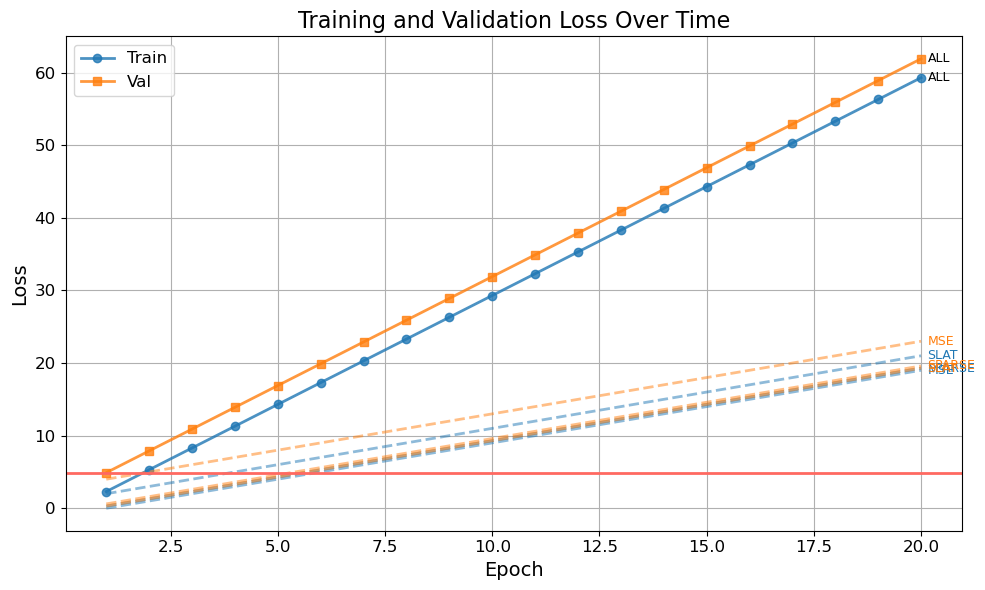

In [104]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, 21)

combined_tr = [sum(values) for values in zip(*[data_tr[key] for key in data_tr.keys()])]
combined_val = [sum(values) for values in zip(*[data_val[key] for key in data_val.keys()])]

bestVal = min(combined_val)

plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(epochs, combined_tr, label="Train", marker='o', linestyle='-', color='#1f77b4', linewidth=2, alpha = 0.8)  # Customize train curve with softer blue color
plt.plot(epochs, combined_val, label="Val", marker='s', linestyle='-', color='#ff7f0e', linewidth=2, alpha = 0.8)
plt.text(epochs[-1] + 0.15, combined_tr[-1], 'ALL', verticalalignment = 'center', fontsize = 9)
plt.text(epochs[-1] + 0.15, combined_val[-1], 'ALL', verticalalignment = 'center', fontsize = 9)

for idx,key in enumerate(list(data_tr.keys())):
    plt.plot(epochs, data_tr[key], linestyle='--', color='#1f77b4', linewidth=2, alpha = 0.5)
    plt.text(epochs[-1] + 0.15, data_tr[key][-1], key, verticalalignment = 'center', fontsize = 9, color = '#1f77b4')

for idx,key in enumerate(list(data_val.keys())):
    plt.plot(epochs, data_val[key], linestyle='--', color='#ff7f0e', linewidth=2, alpha = 0.5)
    plt.text(epochs[-1] + 0.15, data_val[key][-1], key, verticalalignment = 'center', fontsize = 9, color = '#ff7f0e')

plt.axhline(bestVal, linestyle='-', color='#FF6961', linewidth=2, alpha = 1)

plt.title("Training and Validation Loss Over Time", fontsize=16)
plt.xlabel("Epoch", fontsize=14)  
plt.ylabel("Loss", fontsize=14)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(fontsize=12) 
plt.grid(True)  
plt.tight_layout()  

plt.show()


In [63]:
test = {'A': []}
test[list(test.keys())[0]]

[]

In [45]:
a = [np.array([1,2,3]),np.array([4,5,6]),np.array([7,8,9])]
idxs = [0,1]
[x for idx in idxs for x in [a[idx]]]

[array([1, 2, 3]), array([4, 5, 6])]

In [62]:
import pandas as pd
import numpy as np

# Define the data for the DataFrame
data = {
    'Feature1': np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]),
    'Feature4': np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]),
    'Feature5': np.array([2, 8, 5, 3, 2, 2, 8, 5, 3, 2]),
    'Feature6': np.array([2, 1, 5, 32, 2, 2, 1, 5, 32, 2]),
    'Feature7': np.array([2, 3, 4, 0, 2, 2, 3, 4, 0, 2])
}

# Create the DataFrame
df = pd.DataFrame(data)

print(df)


   Feature1  Feature4  Feature5  Feature6  Feature7
0         1       0.1         2         2         2
1         2       0.2         8         1         3
2         3       0.3         5         5         4
3         4       0.4         3        32         0
4         5       0.5         2         2         2
5         1       0.1         2         2         2
6         2       0.2         8         1         3
7         3       0.3         5         5         4
8         4       0.4         3        32         0
9         5       0.5         2         2         2


In [63]:
list(data.values())

[array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]),
 array([2, 8, 5, 3, 2, 2, 8, 5, 3, 2]),
 array([ 2,  1,  5, 32,  2,  2,  1,  5, 32,  2]),
 array([2, 3, 4, 0, 2, 2, 3, 4, 0, 2])]

[[ -45.93055    28.835352]
 [ 194.68057   109.05402 ]
 [  42.049473 -213.49263 ]
 [-252.57896    28.669697]
 [ 105.68342    -9.885505]]


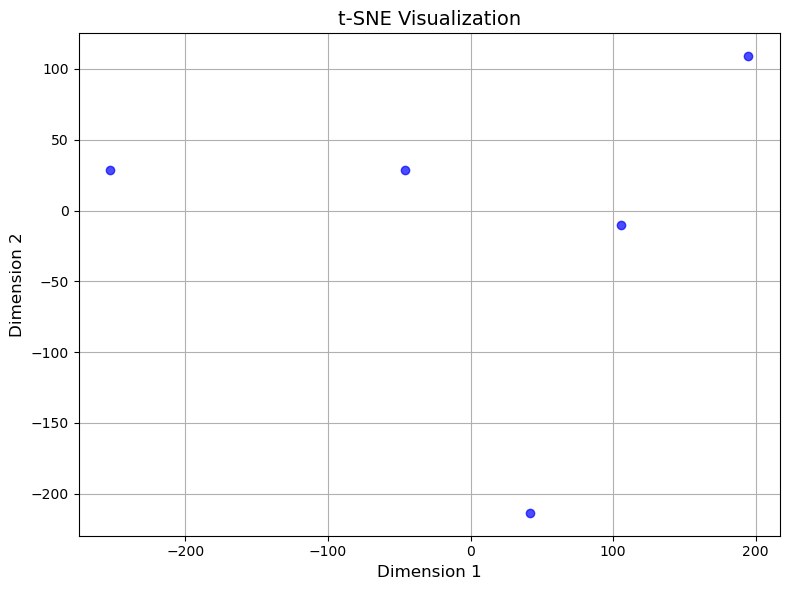

In [64]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vals = np.array(list(data.values()))
x_embedded = TSNE(n_components = 2, perplexity = 2).fit_transform(vals)

print(x_embedded)

plt.figure(figsize=(8, 6))  # Adjust the figure size

plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c='blue', alpha=0.7, label='Data Points')
plt.xlabel('Dimension 1', fontsize=12) 
plt.ylabel('Dimension 2', fontsize=12)
plt.title('t-SNE Visualization', fontsize=14)
#plt.legend(loc='best', fontsize=10) 
plt.grid(True)
plt.tight_layout()
plt.show()


--------------------

### Tests for prediction

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd

from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv


In [3]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [4]:
num_columns = ["age", "creatinine", "kappa", "lambda"]

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_test_imputed = imputer.transform(x_test.loc[:, num_columns])

In [5]:
x_test_imputed

array([[52.        ,  0.9       ,  1.18      ,  1.45      ],
       [53.        ,  0.9       ,  1.45      ,  1.49      ],
       [70.        ,  1.1       ,  1.25      ,  1.72      ],
       ...,
       [72.        ,  1.09548944,  1.02      ,  1.4       ],
       [55.        ,  0.9       ,  0.62      ,  1.15      ],
       [50.        ,  1.1       ,  0.667     ,  1.023     ]])

In [6]:
y_events = y_train[y_train["death"]]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test["death"]]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert (
    train_min <= test_min < test_max < train_max
), "time range or test data is not within time range of training data."

In [7]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


In [8]:
x_test_imputed

array([[52.        ,  0.9       ,  1.18      ,  1.45      ],
       [53.        ,  0.9       ,  1.45      ,  1.49      ],
       [70.        ,  1.1       ,  1.25      ,  1.72      ],
       ...,
       [72.        ,  1.09548944,  1.02      ,  1.4       ],
       [55.        ,  0.9       ,  0.62      ,  1.15      ],
       [50.        ,  1.1       ,  0.667     ,  1.023     ]])

(0.7929451629288902, 411434, 104954, 10253, 48)
(0.5845461764179734, 283124, 188014, 55503, 48)
(0.675223253631379, 358994, 165726, 1921, 48)
(0.6686614075117864, 357350, 167141, 2150, 48)


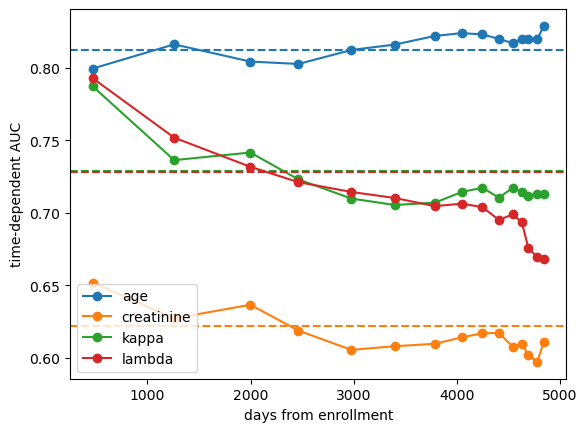

In [18]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()


for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test_imputed[:, i], col, color=f"C{i}")
    ret = concordance_index_ipcw(y_train, y_test, x_test_imputed[:, i], tau=times[-1])
    print(ret)

--------------------------

In [109]:
from sksurv.datasets import load_veterans_lung_cancer

va_x, va_y = load_veterans_lung_cancer()

va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    va_x, va_y, test_size=0.2, stratify=va_y["Status"], random_state=0
)

In [110]:
max(va_y['Survival_in_days'])

999.0

In [111]:
cph = make_pipeline(OneHotEncoder(), CoxnetSurvivalAnalysis(l1_ratio=0.95, fit_baseline_model = True))
cph.fit(va_x_train, va_y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(fit_baseline_model=True,
                                        l1_ratio=0.95))])

In [112]:
va_y_test['Survival_in_days']

array([392.,  11., 156., 340., 117.,   1., 100.,  20., 111.,  33.,   7.,
       162.,   7.,  87., 283.,  45.,  51.,  42.,  43.,  21.,  16.,  54.,
        15., 112.,  12.,  44., 587.,   1.])

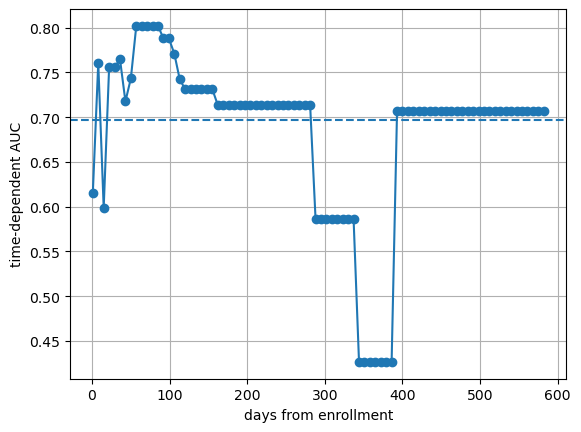

In [113]:
va_times = np.arange(1, 587, 7)
cph_risk_scores = cph.predict(va_x_test, alpha = 0.01)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [114]:
X = cph.predict_cumulative_hazard_function(va_x_test, alpha = None)
X

array([StepFunction(x=array([  2.,   3.,   4.,   7.,   8.,  10.,  12.,  13.,  15.,  18.,  19.,
               20.,  21.,  22.,  24.,  25.,  27.,  29.,  30.,  31.,  35.,  36.,
               48.,  49.,  51.,  52.,  53.,  54.,  56.,  59.,  61.,  63.,  72.,
               73.,  80.,  82.,  83.,  84.,  87.,  90.,  92.,  95.,  97.,  99.,
              100., 103., 105., 110., 111., 117., 118., 122., 123., 126., 132.,
              133., 139., 140., 143., 144., 151., 153., 162., 164., 177., 182.,
              186., 200., 201., 216., 228., 231., 242., 250., 260., 278., 287.,
              314., 357., 378., 384., 389., 411., 467., 553., 991., 999.]), y=array([5.87805937e-03, 1.18537328e-02, 1.79952635e-02, 2.42305808e-02,
              4.98391685e-02, 6.35000999e-02, 7.05009386e-02, 8.46132640e-02,
              9.19652704e-02, 1.14430226e-01, 1.30862908e-01, 1.39436610e-01,
              1.48270109e-01, 1.57625073e-01, 1.76551064e-01, 2.06583379e-01,
              2.17440994e-01, 2.28445577e-

In [115]:
len(va_x_test)

28

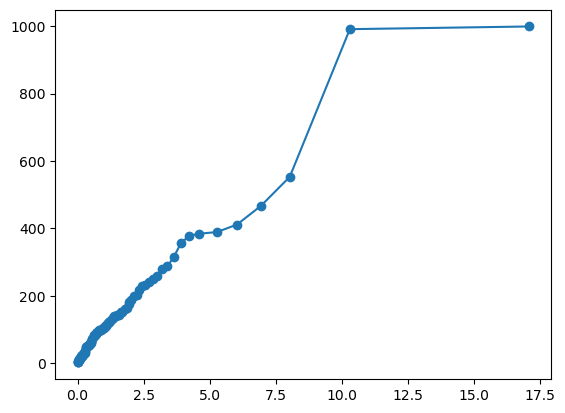

In [116]:
plt.plot(X[0].y, X[0].x, 'o-')

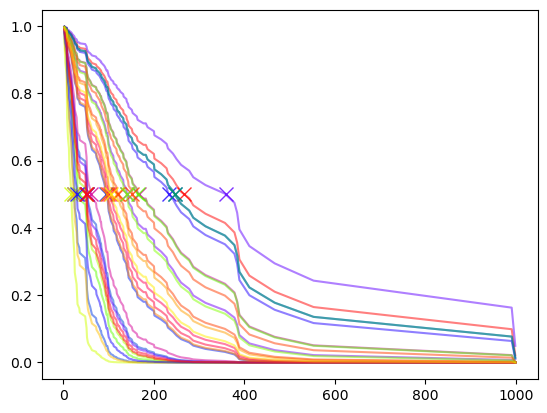

In [124]:
G = cph.predict_survival_function(va_x_test, alpha = None)

for g in G:
    color = plt.cm.prism(np.random.rand())  # Random color
    plt.plot(g.x, g.y, color=color, alpha=0.5)

    median_value = np.interp(0.5, g.y[::-1], g.x[::-1])
    plt.plot(median_value, 0.5, 'x', color=color, alpha=0.8, markersize=10)
plt.show()

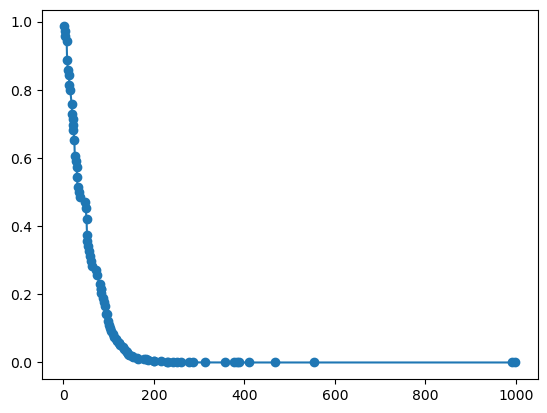

In [22]:
plt.plot(G[0].x, G[0].y, 'o-')

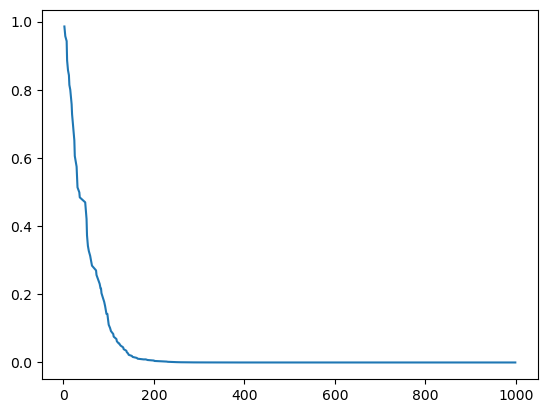

In [27]:
plt.plot(G[0].x, G[0].y)

34.76990354661818


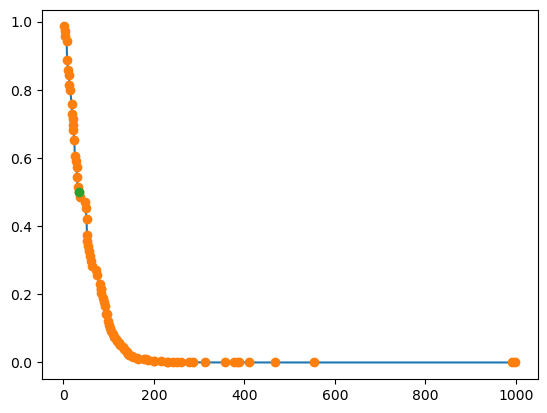

In [63]:
x = G[0].x
y = G[0].y


xnew = np.linspace(min(x), max(x), 1000)
ynew = np.interp(xnew, x, y)
# values have to be reversed as the interpolation expects ascending order
median_value = np.interp(0.5, y[::-1], x[::-1])
print(median_value)

plt.plot(xnew, ynew, '-')
plt.plot(x,y,'o')
plt.plot(median_value, 0.5, 'o')
plt.show()

In [42]:
import scipy.stats as stats

survival_probs = []
for g in G:
    survival_probs += [g.y]
    
survival_probs
lambda_param = np.log(survival_probs[0]) / len(survival_probs[0])
lambda_param

array([-1.63944851e-04, -3.30612254e-04, -5.01905579e-04, -6.75814705e-04,
       -1.39006337e-03, -1.77108017e-03, -1.96634044e-03, -2.35994706e-03,
       -2.56500174e-03, -3.19157141e-03, -3.64989508e-03, -3.88902404e-03,
       -4.13539900e-03, -4.39631815e-03, -4.92418263e-03, -5.76181339e-03,
       -6.06464293e-03, -6.37157157e-03, -7.00780865e-03, -7.65568032e-03,
       -7.98649935e-03, -8.33035457e-03, -8.68067696e-03, -9.09086276e-03,
       -9.94245177e-03, -1.13347646e-02, -1.18307693e-02, -1.23347594e-02,
       -1.28434308e-02, -1.33569626e-02, -1.39049574e-02, -1.44653795e-02,
       -1.50462370e-02, -1.56316900e-02, -1.68563091e-02, -1.75698846e-02,
       -1.75698846e-02, -1.83055384e-02, -1.90585567e-02, -1.98455264e-02,
       -2.06743949e-02, -2.23906507e-02, -2.23906507e-02, -2.42922666e-02,
       -2.53055273e-02, -2.63402331e-02, -2.74280775e-02, -2.85306172e-02,
       -2.96417516e-02, -3.07685467e-02, -3.19335082e-02, -3.31094226e-02,
       -3.31094226e-02, -

In [43]:
stats.expon.fit(lambda_param)

(-0.4764751124946809, 0.43010844352391164)

-------------------------

In [78]:
import torch
import math

from typing import List

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, GridSearchCV
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_concordance_index_ipcw_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

In [95]:
va_x_train = va_x_train[['Age_in_years','Karnofsky_score']]
va_x_test = va_x_test[['Age_in_years','Karnofsky_score']]
cv = KFold(n_splits=5, shuffle = True, random_state = 46)
gcv = GridSearchCV(
            as_concordance_index_ipcw_scorer(CoxnetSurvivalAnalysis(l1_ratio=0.95, fit_baseline_model = True)),
            param_grid = {"estimator__alphas": [[v] for v in [0.001, 0.01]]},
            cv = cv,
            error_score = 0,
            n_jobs = 4,
).fit(va_x_train, va_y_train)

In [97]:
best_model = gcv.best_estimator_.estimator
best_model.predict_survival_function(va_x_test, alpha = 0.001)

array([StepFunction(x=array([  2.,   3.,   4.,   7.,   8.,  10.,  12.,  13.,  15.,  18.,  19.,
               20.,  21.,  22.,  24.,  25.,  27.,  29.,  30.,  31.,  35.,  36.,
               48.,  49.,  51.,  52.,  53.,  54.,  56.,  59.,  61.,  63.,  72.,
               73.,  80.,  82.,  83.,  84.,  87.,  90.,  92.,  95.,  97.,  99.,
              100., 103., 105., 110., 111., 117., 118., 122., 123., 126., 132.,
              133., 139., 140., 143., 144., 151., 153., 162., 164., 177., 182.,
              186., 200., 201., 216., 228., 231., 242., 250., 260., 278., 287.,
              314., 357., 378., 384., 389., 411., 467., 553., 991., 999.]), y=array([9.85665975e-01, 9.71355043e-01, 9.56990456e-01, 9.42657991e-01,
              8.86662215e-01, 8.58270892e-01, 8.43756355e-01, 8.14976974e-01,
              8.00497856e-01, 7.57549652e-01, 7.28000603e-01, 7.13118717e-01,
              6.98112765e-01, 6.82764606e-01, 6.52748128e-01, 6.08828690e-01,
              5.93456015e-01, 5.78286244e-

In [104]:
a,b = train_test_split(va_x_train, test_size = 0.2)
a

,Age_in_years,Karnofsky_score
114,70.0,60.0
112,50.0,60.0
93,60.0,60.0
13,52.0,80.0
20,55.0,40.0
...,...,...
72,52.0,50.0
27,68.0,60.0
80,63.0,20.0
119,63.0,70.0


---------------

In [106]:
from sklearn.metrics import mean_squared_error

current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Implementation', 'Logic', 'predictions_test.csv'))

# expression data
tabular_data = pd.read_csv(somepath, sep = ',', index_col = 0)
mse = mean_squared_error(tabular_data['PFS'], tabular_data['predicted_PFS'])
mse

37.477096963325

In [107]:
tabular_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP,WNT16,PFS,CENSOR,predicted_PFS
id,,,,,,,,,,,,,,,,,,,,,
X1cb9577d90b2a15e59959f7f911e6689,0.377963,0.297245,0.229340,0.401025,0.299808,0.480461,0.318386,0.506086,0.388213,0.365791,...,0.435618,0.360666,0.182575,0.435618,0.438181,0.552851,0.000641,15.211499,0.0,5.536345
X7c31805a23583362dc8ada543ae0bd69,0.396541,0.297886,0.246637,0.383728,0.321589,0.509930,0.338885,0.475336,0.411275,0.354260,...,0.411275,0.354901,0.233824,0.358744,0.375400,0.328636,0.000641,5.782341,0.0,8.317438
X188bc1d97d61f0caececb8fe2eeed462,0.377963,0.302370,0.187060,0.397181,0.348495,0.536835,0.333760,0.445227,0.413837,0.359385,...,0.372197,0.317104,0.250480,0.397822,0.424728,0.303011,0.000641,20.731007,0.0,9.709190
Xfa8012d58e6e95476342cc3e0d7eefa3,0.335042,0.304933,0.130685,0.384369,0.372197,0.503523,0.278668,0.454196,0.333120,0.333760,...,0.400384,0.354260,0.196669,0.436259,0.454837,0.336964,0.000641,1.774127,0.0,9.904053
X70d85275acf86d8a3299e613e53a4181,0.387572,0.262012,0.181935,0.361947,0.274824,0.446509,0.316464,0.546445,0.436899,0.374119,...,0.421525,0.411915,0.247918,0.438821,0.444587,0.566304,0.000641,3.252567,0.0,23.622177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X897660095e14291476c04c07d62ab19c,0.404228,0.290199,0.176169,0.398463,0.319026,0.477899,0.343370,0.529789,0.493914,0.366432,...,0.385010,0.283152,0.301089,0.440103,0.462524,0.433696,0.000641,12.583162,1.0,9.551370
Xbdfa6222382f82a7f9b125c93057cc7b,0.386291,0.310058,0.224215,0.411275,0.315823,0.478539,0.310058,0.497117,0.432415,0.366432,...,0.424728,0.421525,0.264574,0.449071,0.425368,0.597694,0.000641,5.552361,1.0,5.576590
Xceed74a24dea8bbb00de34feee199cdc,0.357463,0.248559,0.217809,0.360026,0.237028,0.439462,0.269058,0.548366,0.461883,0.393978,...,0.487508,0.429853,0.308136,0.418322,0.429212,0.361947,0.000641,10.250513,1.0,9.600346
